<a href="https://colab.research.google.com/github/makkimaki/VAEprojects/blob/master/Convolutional_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from scipy.stats import norm

import glob
import imageio
import PIL
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
import time

np.random.seed(42)
print(tf.__version__)

2.3.0


In [56]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [57]:
train_images.shape

(60000, 28, 28)

In [58]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > 0.5, 1.0, 0.0).astype("float32")

train_images_preprocessed = preprocess_images(train_images)
test_images_preprocessed = preprocess_images(test_images)

In [59]:
train_images_preprocessed.shape

(60000, 28, 28, 1)

Text(0.5, 1.0, 'preprocessed image')

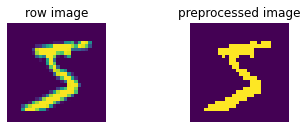

In [7]:
plt.figure(1)
plt.subplot(221)
plt.imshow(train_images[0, :, :])
plt.axis("off")
plt.title("row image")

plt.subplot(222)
plt.imshow(train_images_preprocessed[0, :, :, 0])
plt.axis("off")
plt.title("preprocessed image")

In [8]:
train_size = 60000
batch_size = 32
test_size = 10000

## Use tf.data to batch and shuffle the data

In [9]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images_preprocessed).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images_preprocessed).shuffle(test_size).batch(batch_size))

In [10]:
train_dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [50]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
         tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
         tf.keras.layers.Conv2D(
             filters=32, kernel_size=3, strides=(2,2), activation="relu"),
         tf.keras.layers.Conv2D(
             filters=64, kernel_size=3, strides=(2,2), activation="relu"),
         tf.keras.layers.Flatten(),
         # no activation
         tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
         tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
         tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
         tf.keras.layers.Reshape(target_shape=(7,7,32)),
         tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
         tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
         tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding="same"),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * 0.5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [51]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2 * np.pi)
  return tf.reduce_sum(
      -0.5 * ((sample - mean)**2 * tf.exp(-logvar) + logvar + log2pi), axis= raxis 
  )

def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2,3])
  logpz = log_normal_pdf(z, 0, 0)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [52]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so 
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape = [num_examples_to_generate, latent_dim])

model_cvae = CVAE(latent_dim)

In [53]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:0], cmap="gray")
    plt.axis("off")

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig("image_at_epoch_{:04d}.png".format(epoch))
  plt.show()

In [54]:
# pick a sample of the test set for generating ouput images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

In [66]:
print(test_sample.shape)
print(train_dataset)
print(test_dataset)

(16, 28, 28, 1)
<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>
<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>


TypeError: ignored

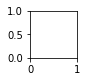

In [64]:
generate_and_save_images(model_cvae, 0, test_sample)

for epoch in range(1, epochs+1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(mode_cvae, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model_cvae, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print("Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}".format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model_cvae, epoch, test_sample)